# Sine Combination Networks

We know that any continuous signal can be represented as a sum of sinusoids. The question is, how many sinusoids do we need to represent a signal? In this notebook, we will explore this question.

In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import jax
import jax.numpy as jnp
import optax

from tinygp import kernels, GaussianProcess

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"

## Random Combination of Sinusoids

(100, 1) (100, 1)


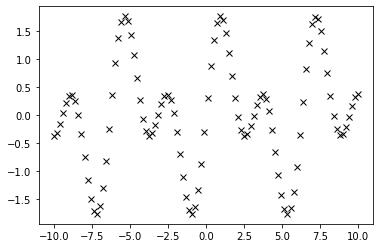

In [28]:
N = 100
x = jnp.linspace(-10, 10, N).reshape(-1, 1)
y = jnp.sin(x) + jnp.sin(2*x)
plt.plot(x, y, "kx");
print(x.shape, y.shape)

## Recover the Signal

In [29]:
def get_weights():
    w1, w2 = 2.0, 4.0
    return w1, w2
    
def get_sine(weights, x):
    w1, w2 = weights
    return jnp.sin(w1*x) + jnp.sin(w2*x)

def loss_fn(weights, x, y):
    output = get_sine(weights, x)
    return jnp.mean((output.ravel() - y.ravel())**2)

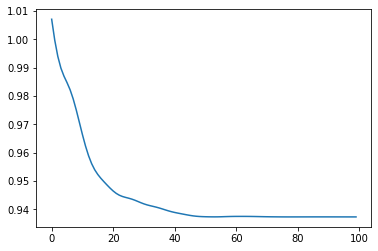

In [30]:
key = jax.random.PRNGKey(2)
epochs = 100

weights = get_weights()
initial_loss = loss_fn(weights, x, y)
optimizer = optax.adam(1e-2)
state = optimizer.init(weights)

value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
weights_history = []
loss_history = []
loss, grads = value_and_grad_fn(weights, x, y)
for epoch in range(epochs):
    updates, state = optimizer.update(grads, state)
    weights = optax.apply_updates(weights, updates)
    loss, grads = value_and_grad_fn(weights, x, y)
    weights_history.append(weights)
    loss_history.append(loss)
    
plt.plot(loss_history);

(Array(1.9798928, dtype=float32), Array(4.3507533, dtype=float32))


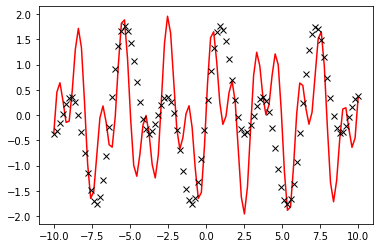

In [31]:
output = get_sine(weights, x)
plt.plot(x, output, "r")
plt.plot(x, y, "kx")
print(weights)